### MMMLU – Exploratory Data Analysis (EDA)

Analysis of the combined, multilingual **Multilingual Massive Multitask Language Understanding** dataset (all available language configurations from their 'test' splits).

%% [markdown]
## 🔹 MMMLU EDA

This notebook quickly analyzes the 'test' splits of the multilingual MMMLU dataset. The main goal is to gather insights that will inform how we preprocess data for the finetuning experiments in this lab.

**Workflow and Choices**

We started by loading all 14 language-specific 'test' splits from the `openai/mmmlu` dataset and combined them into one. This gives a full view of the multilingual data. A `language` column was added to keep track of the source of each question.

Basic checks confirmed the data schema and showed no null values across the 196,588 examples.

In terms of distributions, all 14 language configurations initially have an equal number of questions (14,042 each), and the global distribution of A, B, C, D answers is relatively balanced. We also looked at the most common subjects.

A key part of this EDA was analyzing token lengths using a `roberta-base` tokenizer. We looked at the lengths of 'Question' fields alone and, more critically for model input, the combined 'Question + Choices' text. This analysis showed that approximately 61.75% of these combined prompts are 256 tokens or fewer.

## 0  Install & imports

In [51]:
# !pip -q install --upgrade datasets transformers seaborn matplotlib scikit-learn

In [52]:
from datasets import get_dataset_config_names, load_dataset, concatenate_datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 1  Load and Combine Data from All Language Configurations

We will load the 'test' split for each of the 14 language-specific configurations. 
These will be combined into a single dataset for EDA. No token length filtering or sampling is done at this EDA stage.

In [53]:
SEED = 42 # Seed for any shuffling if needed

config_names_all = get_dataset_config_names("openai/mmmlu")
language_configs = [name for name in config_names_all if name != "default"]
print(f"Found {len(language_configs)} language-specific configurations: {language_configs}")

all_lang_datasets = []
language_question_counts = {}

for config_name in language_configs:
    print(f"\nProcessing configuration: {config_name}...")
    try:
        lang_ds = load_dataset("openai/mmmlu", config_name, split="test")
        count_loaded = len(lang_ds)
        print(f"  Loaded {count_loaded} examples for {config_name}.")

        if count_loaded > 0:
            lang_ds = lang_ds.map(lambda example: {'language': config_name})
            all_lang_datasets.append(lang_ds)
            language_question_counts[config_name] = count_loaded
        else:
            print(f"  No examples found for {config_name}, skipping.")
            language_question_counts[config_name] = 0

    except Exception as e:
        print(f"  Could not process configuration {config_name}: {e}")
        language_question_counts[config_name] = 0 

if all_lang_datasets:
    ds_eda = concatenate_datasets(all_lang_datasets)
    ds_eda = ds_eda.shuffle(seed=SEED)
    print(f"\nCombined dataset for EDA created with {len(ds_eda)} examples from {len(all_lang_datasets)} languages.")
else:
    print("\nNo data was loaded. EDA cannot proceed. Please check dataset availability.")
    ds_eda = None 

if ds_eda:
    print(ds_eda)

Found 14 language-specific configurations: ['AR_XY', 'BN_BD', 'DE_DE', 'ES_LA', 'FR_FR', 'HI_IN', 'ID_ID', 'IT_IT', 'JA_JP', 'KO_KR', 'PT_BR', 'SW_KE', 'YO_NG', 'ZH_CN']

Processing configuration: AR_XY...
  Loaded 14042 examples for AR_XY.

Processing configuration: BN_BD...
  Loaded 14042 examples for BN_BD.

Processing configuration: DE_DE...
  Loaded 14042 examples for DE_DE.

Processing configuration: ES_LA...
  Loaded 14042 examples for ES_LA.

Processing configuration: FR_FR...
  Loaded 14042 examples for FR_FR.

Processing configuration: HI_IN...
  Loaded 14042 examples for HI_IN.

Processing configuration: ID_ID...
  Loaded 14042 examples for ID_ID.

Processing configuration: IT_IT...
  Loaded 14042 examples for IT_IT.

Processing configuration: JA_JP...
  Loaded 14042 examples for JA_JP.

Processing configuration: KO_KR...
  Loaded 14042 examples for KO_KR.

Processing configuration: PT_BR...
  Loaded 14042 examples for PT_BR.

Processing configuration: SW_KE...
  Loaded 1404

## 2  Language Distribution by Question Count

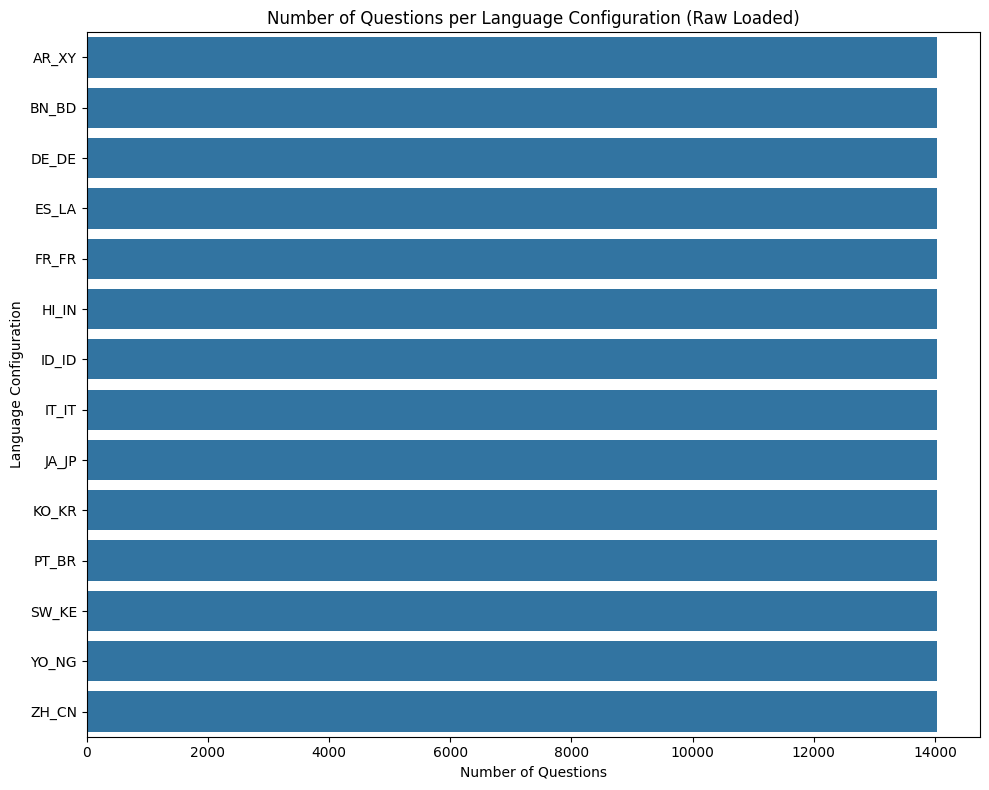

All 14 language configurations have the same number of questions: 14042


In [54]:
if language_question_counts:
    lang_counts_df = pd.DataFrame(list(language_question_counts.items()), columns=['Language', 'Question Count']).sort_values(by='Question Count', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Question Count', y='Language', data=lang_counts_df, orient='h')
    plt.title('Number of Questions per Language Configuration (Raw Loaded)')
    plt.xlabel('Number of Questions')
    plt.ylabel('Language Configuration')
    plt.tight_layout()
    plt.show()
    
    if lang_counts_df['Question Count'].nunique() == 1:
        print(f"All {len(lang_counts_df)} language configurations have the same number of questions: {lang_counts_df['Question Count'].iloc[0]}")
    else:
        print("Question counts differ across language configurations.")
        print(lang_counts_df)
else:
    print("Language question counts not available.")

## 3  Quick schema check (on combined multilingual dataset)

In [55]:
if ds_eda and len(ds_eda) > 0:
    print(ds_eda.features)
    head_df_eda = ds_eda.select(range(min(5, len(ds_eda)))).to_pandas()
    print(head_df_eda)
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping schema check.")

{'Unnamed: 0': Value(dtype='int64', id=None), 'Question': Value(dtype='string', id=None), 'A': Value(dtype='string', id=None), 'B': Value(dtype='string', id=None), 'C': Value(dtype='string', id=None), 'D': Value(dtype='string', id=None), 'Answer': Value(dtype='string', id=None), 'Subject': Value(dtype='string', id=None), 'language': Value(dtype='string', id=None)}
   Unnamed: 0                                           Question  \
0          81  Seorang peneliti sedang mempelajari insiden fl...   
1          50  सकारात्मक कार्रवाई में किसी संगठन के कार्यबल क...   
2          48  本问题涉及以下信息。\n“今天，这个国家一半的人完全无力从成文法上抹去一部不公正的法律，或在...   
3          43  As estruturas que agem como locais de troca ga...   
4          99  사적 유물론’(historical materialism, HM)이라는 용어의 정의와...   

                                                   A  \
0            Penurunan konsentrasi kortisol serum AM   
1              सक्रिय, समूह, कम प्रतिनिधित्व, वृद्धि   
2                               《谢尔曼反托拉斯法案》（1890 年）。   


## 4  Row counts & nulls (on combined multilingual dataset)

In [56]:
if ds_eda and len(ds_eda) > 0:
    print("Total rows in combined EDA dataset:", len(ds_eda))
    print(ds_eda.to_pandas().isna().sum())
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping row counts and null check.")

Total rows in combined EDA dataset: 196588
Unnamed: 0    0
Question      0
A             0
B             0
C             0
D             0
Answer        0
Subject       0
language      0
dtype: int64


## 5  Answer distribution (global, on combined multilingual dataset)

In [57]:
if ds_eda and len(ds_eda) > 0:
    ans_counts_eda = ds_eda.to_pandas()["Answer"].value_counts().sort_index()
    print(ans_counts_eda)
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping answer distribution.")

Answer
A    45110
B    48465
C    50151
D    52862
Name: count, dtype: int64


## 6  Subject distribution (on combined multilingual dataset)

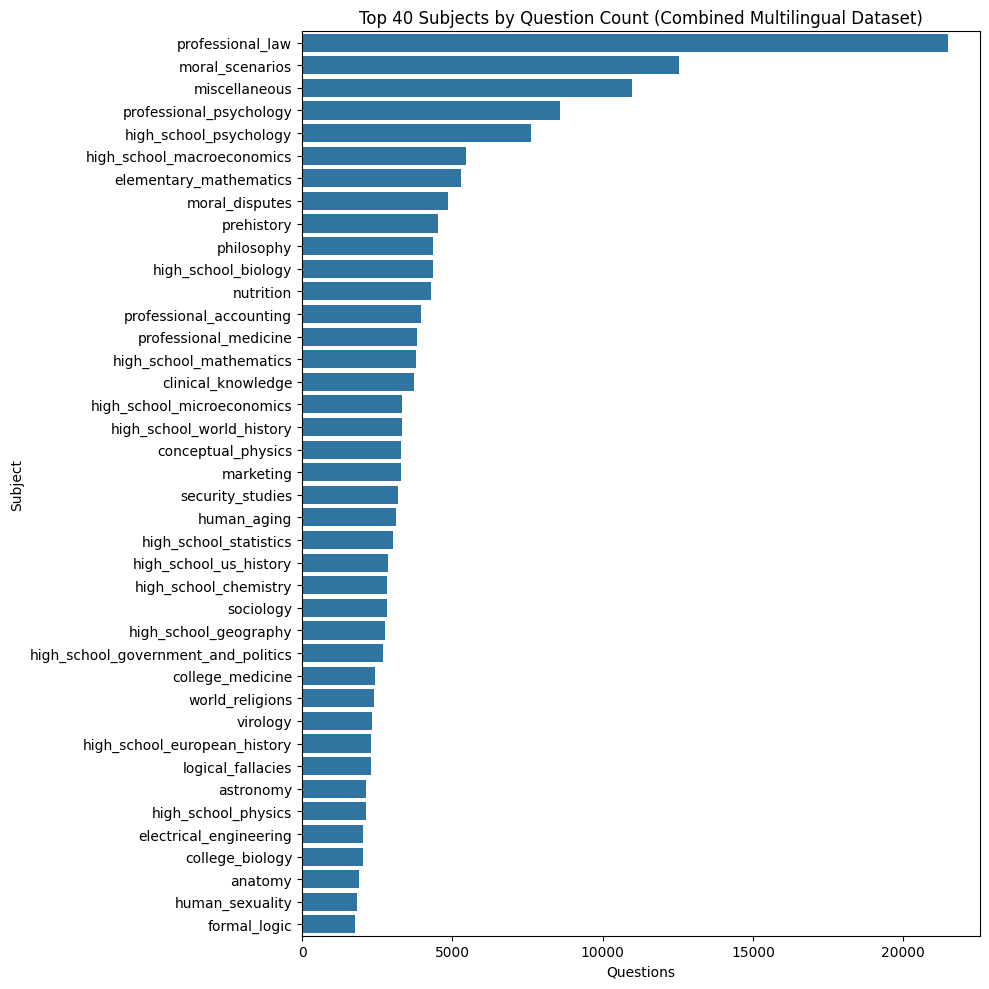

In [58]:
if ds_eda and len(ds_eda) > 0:
    subj_counts_eda = ds_eda.to_pandas()["Subject"].value_counts()
    TOP_N = 40  
    plt.figure(figsize=(10, max(4, TOP_N * 0.25)))
    sns.barplot(x=subj_counts_eda.head(TOP_N).values, y=subj_counts_eda.head(TOP_N).index, orient="h")
    plt.title(f"Top {TOP_N} Subjects by Question Count (Combined Multilingual Dataset)")
    plt.xlabel("Questions")
    plt.ylabel("Subject")
    plt.tight_layout()
    plt.show()
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping subject distribution plot.")

## 7  Choice‑balance per subject (on combined multilingual dataset)

In [59]:
if ds_eda and len(ds_eda) > 0:
    choice_balance_eda = ds_eda.to_pandas().groupby(["Subject", "Answer"]).size().unstack(fill_value=0)
    print(choice_balance_eda.head())
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping choice balance analysis.")

Answer                A    B    C     D
Subject                                
abstract_algebra    308  364  434   294
anatomy             350  476  630   434
astronomy           378  392  644   714
business_ethics     420  364  323   293
clinical_knowledge  798  994  812  1106


## 8  Token length stats (Question Only - on combined multilingual dataset)
This shows the distribution of token lengths for the 'Question' field *before* any filtering, which is crucial for deciding on a filtering threshold.

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


Token length statistics for 'Question' field (full combined multilingual dataset):
count    196588.00000
mean        200.06419
std         346.15254
min           2.00000
25%          38.00000
50%          80.00000
75%         202.00000
max        9055.00000
dtype: float64


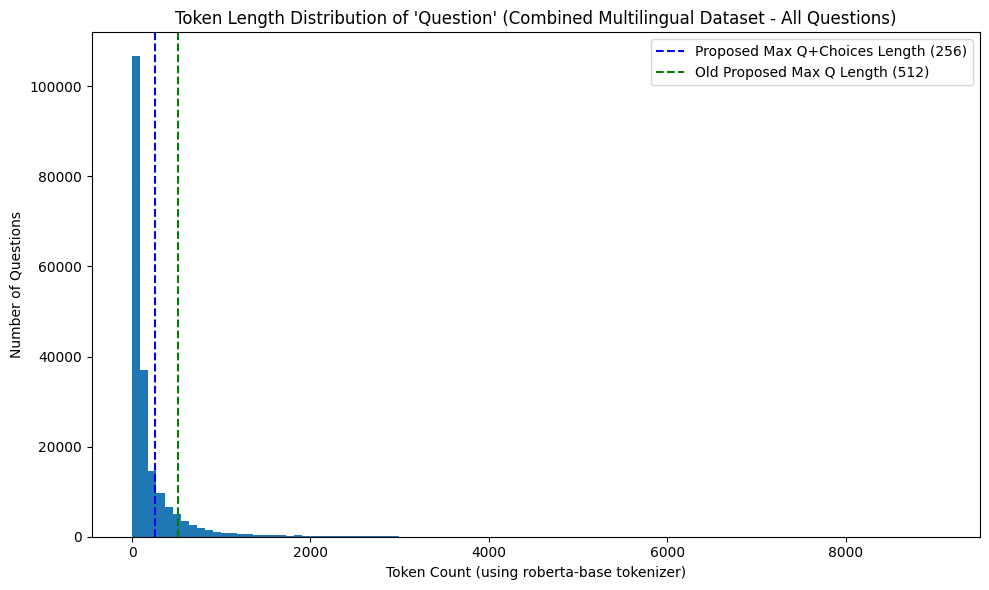

In [60]:
if ds_eda and len(ds_eda) > 0:
    tokenizer_for_stats = AutoTokenizer.from_pretrained("roberta-base") 
    q_series_eda_full = ds_eda["Question"]
    lengths_q_only_eda_full = [len(tokenizer_for_stats.tokenize(q)) for q in q_series_eda_full]
    
    print("Token length statistics for 'Question' field (full combined multilingual dataset):")
    print(pd.Series(lengths_q_only_eda_full).describe())
    
    plt.figure(figsize=(10, 6))
    plt.hist(lengths_q_only_eda_full, bins=100) 
    plt.title(f"Token Length Distribution of 'Question' (Combined Multilingual Dataset - All Questions)")
    plt.xlabel("Token Count (using roberta-base tokenizer)")
    plt.ylabel("Number of Questions")
    plt.axvline(x=256, color='b', linestyle='--', label='Proposed Max Q+Choices Length (256)')
    plt.axvline(x=512, color='g', linestyle='--', label='Old Proposed Max Q Length (512)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping token length stats for 'Question' field.")

## 8.1 Token length stats (Question + Choices - on combined multilingual dataset)
This shows the distribution of token lengths for the combined 'Question' and 'Choices' text. This is critical for deciding the filtering threshold for models like Flan-T5.

Token length statistics for 'Question + Choices' (full combined multilingual dataset):
count    196588.000000
mean        342.498560
std         438.149235
min          25.000000
25%         111.000000
50%         192.000000
75%         397.000000
max        9383.000000
dtype: float64
61.75% of 'Question + Choices' sequences are <= 256 tokens.


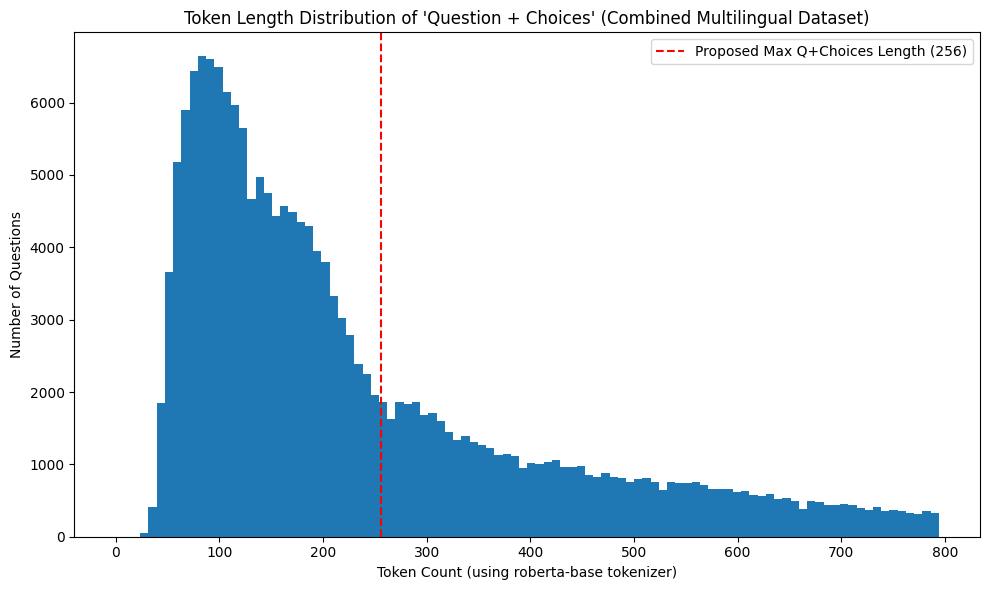

In [61]:
if ds_eda and len(ds_eda) > 0:
    # Using the same roberta-base tokenizer for consistency in EDA stats
    # tokenizer_for_stats is already defined from the previous cell
    
    combined_texts = []
    for example in ds_eda:
        text = f"Question: {example['Question']}\nChoices:\nA: {example['A']}\nB: {example['B']}\nC: {example['C']}\nD: {example['D']}"
        combined_texts.append(text)
    
    lengths_q_plus_choices = [len(tokenizer_for_stats.tokenize(t)) for t in combined_texts]
    
    print("Token length statistics for 'Question + Choices' (full combined multilingual dataset):")
    stats_q_plus_choices = pd.Series(lengths_q_plus_choices).describe()
    print(stats_q_plus_choices)
    
    # Calculate percentage of data <= 256 tokens
    num_less_than_256 = sum(1 for length in lengths_q_plus_choices if length <= 256)
    percent_less_than_256 = (num_less_than_256 / len(lengths_q_plus_choices)) * 100 if len(lengths_q_plus_choices) > 0 else 0
    print(f"{percent_less_than_256:.2f}% of 'Question + Choices' sequences are <= 256 tokens.")

    plt.figure(figsize=(10, 6))
    # Adjust histogram range for better visualization around the 256 mark
    # Show data up to a reasonable upper bound, e.g., 1024, or based on quantiles
    upper_plot_limit = min(1024, int(stats_q_plus_choices['max']))
    if '75%' in stats_q_plus_choices:
        upper_plot_limit = min(1024, int(stats_q_plus_choices['75%'] * 2)) # Show a bit beyond 75th percentile
    upper_plot_limit = max(upper_plot_limit, 300) # Ensure 256 is visible

    plt.hist(lengths_q_plus_choices, bins=100, range=(0, upper_plot_limit)) 
    plt.title(f"Token Length Distribution of 'Question + Choices' (Combined Multilingual Dataset)")
    plt.xlabel("Token Count (using roberta-base tokenizer)")
    plt.ylabel("Number of Questions")
    plt.axvline(x=256, color='r', linestyle='--', label='Proposed Max Q+Choices Length (256)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Combined dataset (ds_eda) is empty or None. Skipping token length stats for 'Question + Choices'.")

## 9  Key takeaways (based on the combined multilingual dataset)
* The analysis is now performed on the full 'test' splits from all available language configurations.
* The language distribution plot shows if question counts are balanced across languages.
* Token length distributions for 'Question' only and 'Question + Choices' help justify filtering thresholds. Filtering 'Question + Choices' at 256 tokens seems viable for models with smaller context windows like Flan-T5, while still retaining a significant portion of the data.